In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as npy # linear algebra
import pandas as pds # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator as ImgDataGen

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os, sys, time, warnings, sklearn
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [6]:
from tensorflow.python.framework.config import set_memory_growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
else:
    print('No GPU found')

No GPU found


In [2]:
TRAIN_PATH='data/train'
TEST_PATH='data/test'
train_kcn_img_path=TRAIN_PATH +'/angry'

In [3]:
x=plt.imread(train_kcn_img_path+'/im0.png')
x.shape

(48, 48)

## Data Augmentation

In [4]:
target_size=(48, 48)
batch_size=64

## Train and Validation Image Data Generator instance. 
# We will not apply any transformon specific orientations or features and no initial rescale to the image
# We'll only split the image data into train and validation set
# Define data augmentation parameters
trainValidation_data_generator = ImgDataGen(
                                            #rescale=1./225,
                                            rotation_range=10,  # Randomly rotate images by up to 10 degrees
                                            zoom_range=0.2,  # Randomly zoom images by up to 20%
                                            width_shift_range=0.1,  # Randomly shift images horizontally by up to 10% of the image width
                                            height_shift_range=0.1,  # Randomly shift images vertically by up to 10% of the image height
                                            shear_range=0.2,  # Randomly apply shearing transformations
                                            horizontal_flip=True,  # Randomly flip images horizontally
                                            fill_mode='nearest',  # Fill in missing pixels with the nearest value
                                            validation_split=0.3    # set the validation split                                
                                            )

# Test Image Data Generator instance for Test data
test_data_generator = ImgDataGen()

# Set a random seed to synchronize the shuffle order across different runs of the generator
# trainValidation_data_generator.set_seed(42)


### Create Train, Validation, and Test Generators

In [5]:
# Successfully mapped the train-images to their classes from the dataframe. Now let's do the same for the test-images. 
# Here, I will only be rescaling. No other transformations are applies, to preserve originality of the images.


## Mapping images to their classes.
print('Train Set Generated - ',end=' ') 
train_generator = trainValidation_data_generator.flow_from_directory(
                                                            directory=TRAIN_PATH, 
                                                            target_size=target_size,
                                                            batch_size=batch_size,
                                                            class_mode='categorical', 
                                                            color_mode='rgb', 
                                                            shuffle=True, 
                                                            subset='training' # set as training data
                                                            # seed=1,
                                                        )
## Mapping images to their classes.
print('Validation Set Generated - ',end=' ') 
validation_generator = trainValidation_data_generator.flow_from_directory(
                                                            directory=TRAIN_PATH, 
                                                            target_size=target_size,
                                                            batch_size=batch_size,
                                                            class_mode='categorical', 
                                                            color_mode='rgb', 
                                                            shuffle=True, 
                                                            subset='validation' # set as validation data
                                                            # seed=1,
                                                        )

## Mapping images to their classes.
print('Test Set Generated - ',end=' ') 
test_generator = test_data_generator.flow_from_directory(
                                        TEST_PATH, 
                                        target_size=target_size,
                                        class_mode='categorical', 
                                        color_mode='rgb', 
                                        shuffle=True, 
                                        # seed=1,
                                        batch_size=batch_size
                                        )

Train Set Generated -  Found 20099 images belonging to 7 classes.
Validation Set Generated -  Found 8610 images belonging to 7 classes.
Test Set Generated -  Found 7178 images belonging to 7 classes.


In [6]:
# From the generator we can get information we will need later
class_dictionary = train_generator.class_indices
class_keys = list(train_generator.class_indices.keys())
class_values = list(train_generator.class_indices.values())
class_count = len(class_keys)

train_images, train_labels = next(train_generator)
validation_images, validation_labels = next(validation_generator)
test_images, test_labels = next(test_generator)


print('The 3 identified classes are: ',class_dictionary)
print('Class count: ', class_count)

print('\nX_train shape: ', train_images.shape)
print('y_train shape: ', train_labels.shape)

print('\nX_test shape: ', test_images.shape)
print('y_test shape: ', test_labels.shape)


The 3 identified classes are:  {'angry': 0, 'disgusted': 1, 'fearful': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprised': 6}
Class count:  7

X_train shape:  (64, 48, 48, 3)
y_train shape:  (64, 7)

X_test shape:  (64, 48, 48, 3)
y_test shape:  (64, 7)


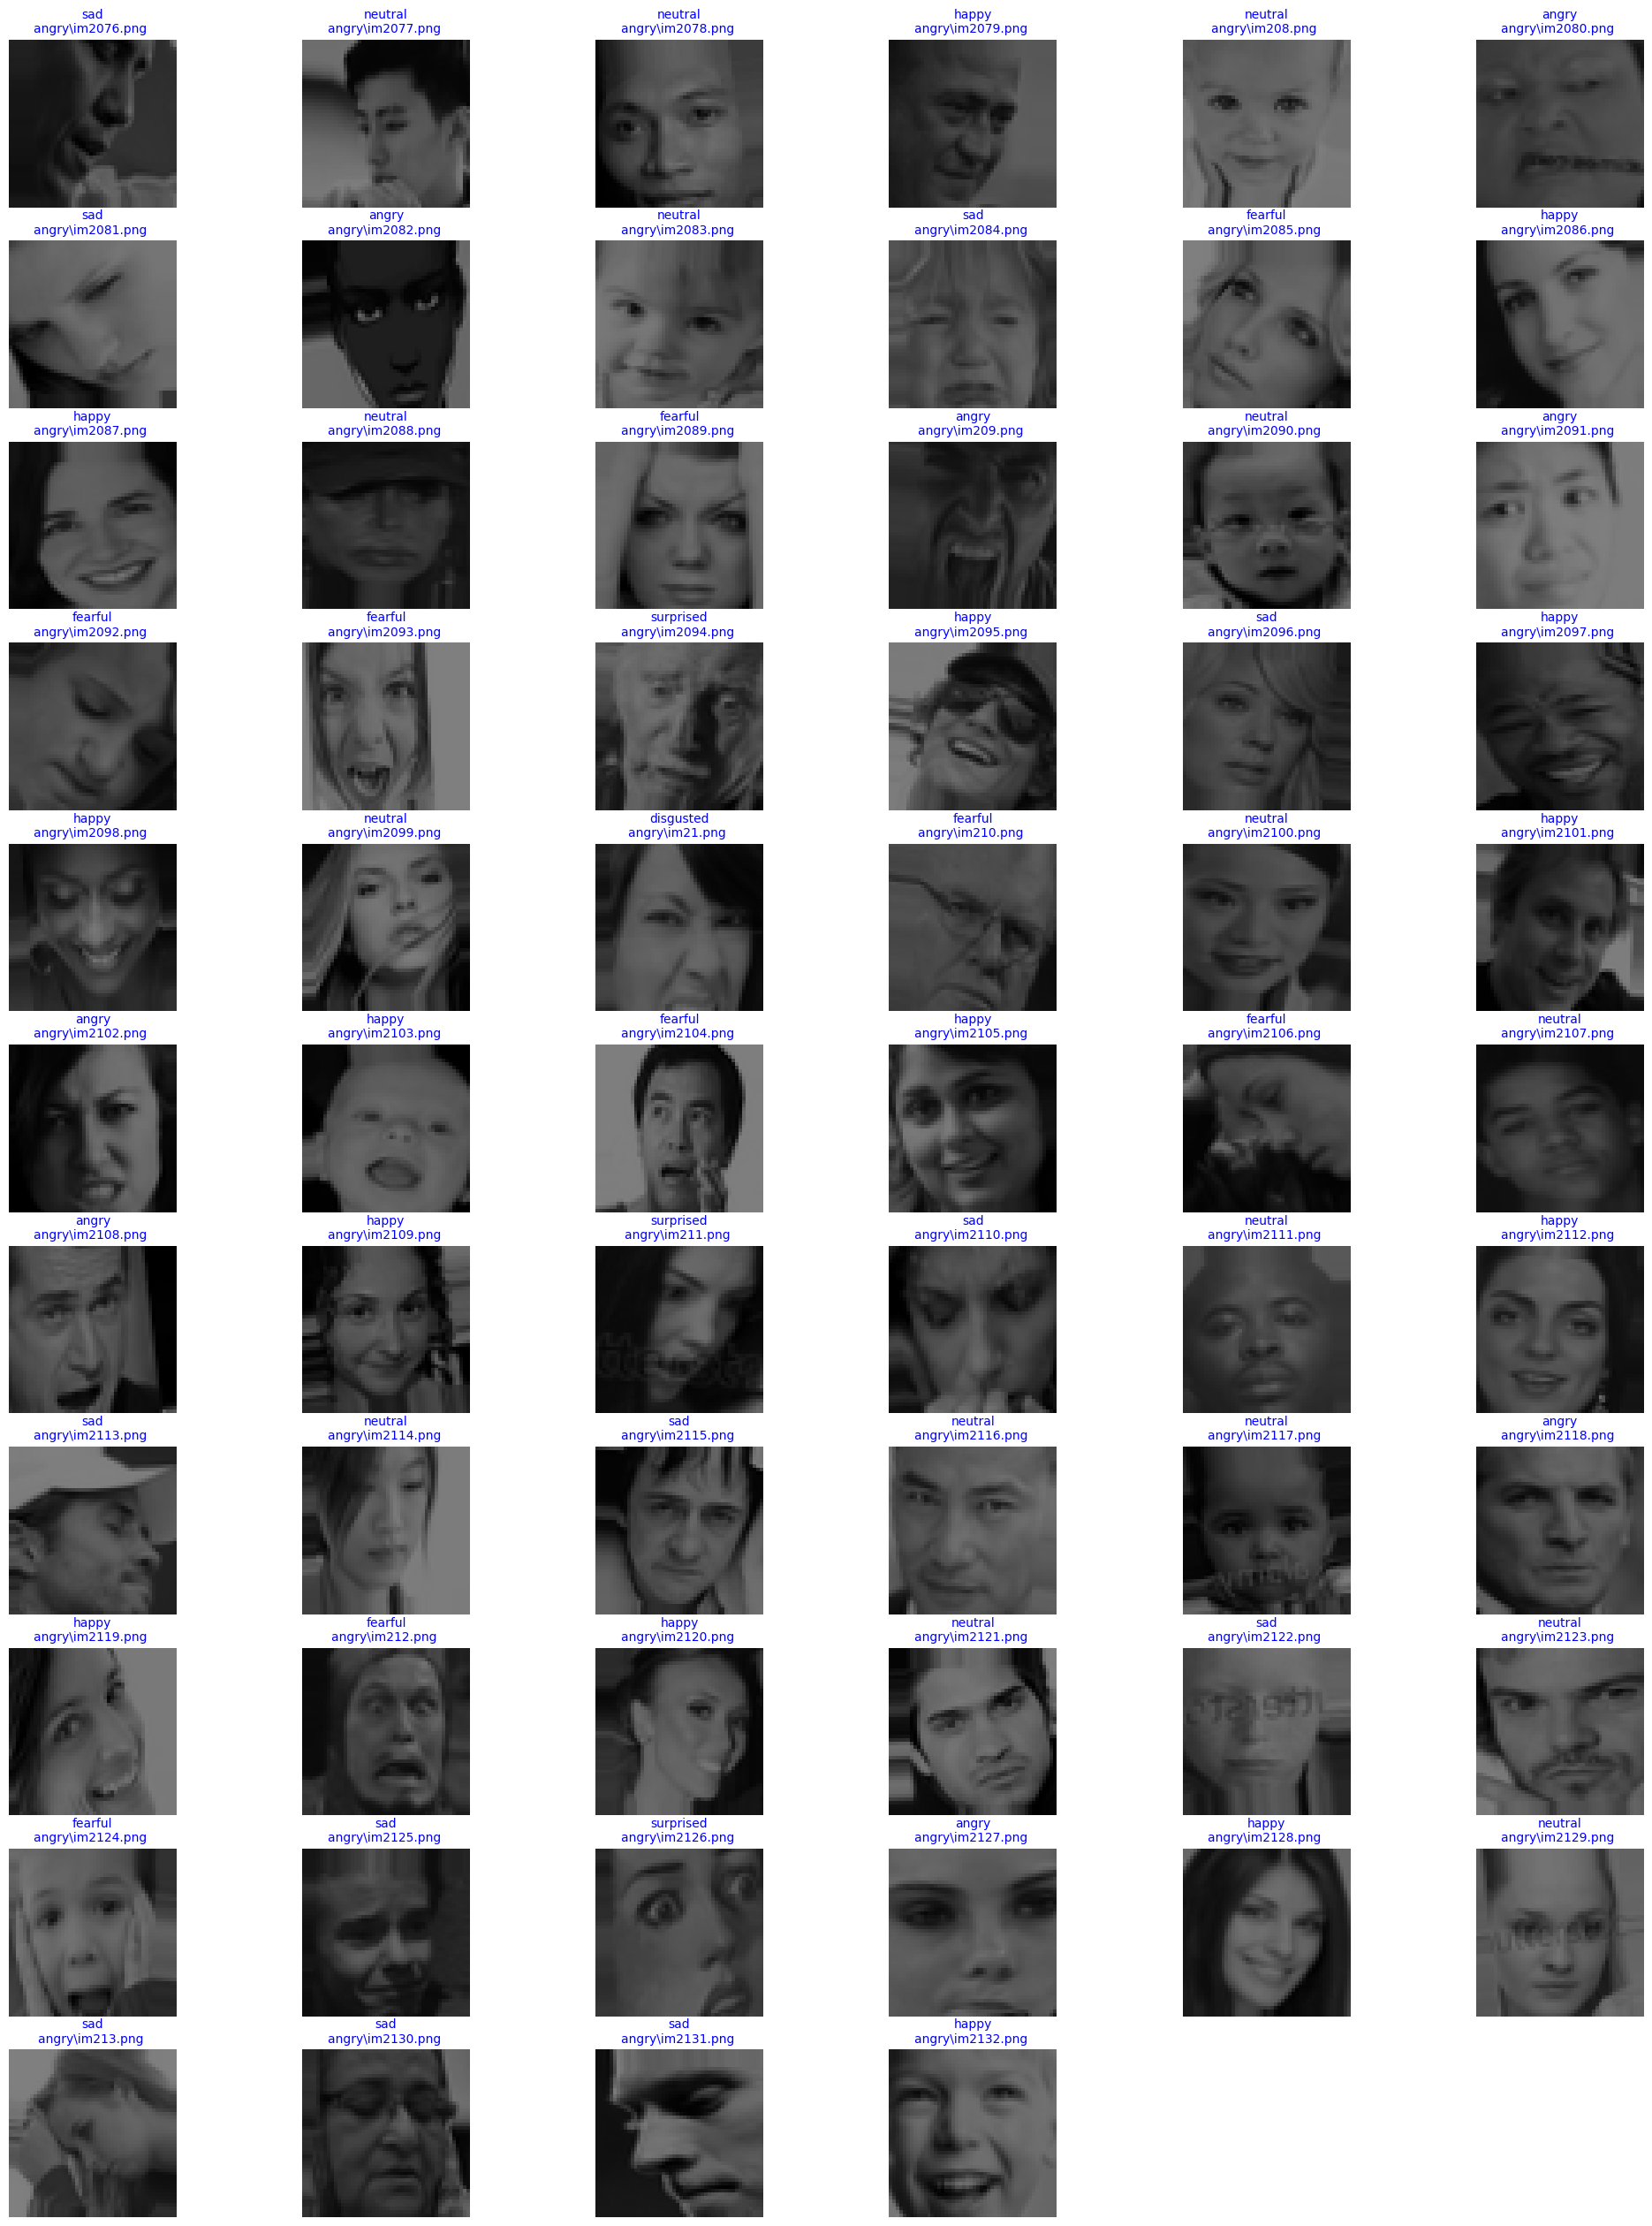

In [7]:
# Get the sample images, labels, and their filenames 
# To get the correct filename, turn off the shuffle
def plotImageWithNames(gen, batch_size):
    images, labels = next(gen)
    filenames = gen.filenames
    classes = list(gen.class_indices.keys())
    
    plt.figure(figsize=(25, batch_size/2))
    length=len(labels)
    if length<batch_size:  
        r=length
    else:
        r=batch_size
    for i in range(r):        
        plt.subplot(int(batch_size/6)+1, 6, i + 1)
        image=images[i]/512 
        plt.imshow(image)
        index=npy.argmax(labels[i])
        class_name=classes[index]
        filename=gen.filenames[i]
        plt.title(label=f"{class_name}\n{filename} ", color='blue', fontsize=10)
        plt.axis('off')
    plt.show()

plotImageWithNames(train_generator, batch_size=batch_size)

## Create the Model

In [8]:
from tensorflow import keras
from sklearn import set_config
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator as ImgDataGen
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPooling2D, Activation, BatchNormalization
from tensorflow.keras.models import Sequential, load_model

# from tensorflow.keras import layers, optimizers, metrics, regularizers, models
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.metrics import categorical_crossentropy, sparse_categorical_crossentropy


In [9]:
# define the image shape for the input layer
input_shape=(target_size[0], target_size[1], 3)
batch_size = batch_size
epochs=150
ask_epoch=60

## Build and Compile CNN

In [10]:
# define the model architecture
cnn_model = Sequential(name='CNN')
cnn_model.add(Conv2D(32, (3, 3), name='conv2d_1', activation='relu', input_shape=input_shape))
cnn_model.add(MaxPooling2D((2, 2), name='max_pooling2d_1'))
cnn_model.add(Conv2D(64, (3, 3), name='conv2d_2', activation='relu'))
cnn_model.add(MaxPooling2D((2, 2), name='max_pooling2d_2'))
cnn_model.add(Conv2D(128, (3, 3), name='conv2d_3', activation='relu'))
cnn_model.add(MaxPooling2D((2, 2), name='max_pooling2d_3'))
# cnn_model.add(Dropout(0.5, name='dropout'))
cnn_model.add(Flatten(name='flatten'))
cnn_model.add(Dense(512, name='dense_1', activation='relu'))
cnn_model.add(Dropout(0.2, name='dropout_1'))
# cnn_model.add(Dense(128, name='dense_2', activation='relu'))
cnn_model.add(Dense(class_count, name='output_layer_dense', activation='softmax'))

# compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# View the model summary
cnn_model.summary()


Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 46, 46, 32)        896       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 4, 4, 128)        0       

In [11]:
# Plot the Model Diagram
set_config(display="diagram")

keras.utils.plot_model(cnn_model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


Create a Custom Keras Callback to Continue or Halt Training

In [12]:
# Code by https://www.kaggle.com/code/gpiosenka/callback-to-continue-or-halt-training-f1-90
class ASK(keras.callbacks.Callback):
    def __init__ (self, model, epochs,  ask_epoch): # initialization of the callback
        super(ASK, self).__init__()
        self.model=model               
        self.ask_epoch=ask_epoch
        self.subask_epoch = int(ask_epoch/2)
        self.epochs=epochs
        self.ask=True # if True query the user on a specified epoch
        
    def on_train_begin(self, logs=None): # this runs on the beginning of training
        if self.ask_epoch == 0: 
            print('you set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch=1
        if self.ask_epoch >= self.epochs: # you are running for epochs but ask_epoch>epochs
            print('ask_epoch >= epochs, will train for ', epochs, ' epochs', flush=True)
            self.ask=1 # do not query the user
        if self.epochs == 1:
            self.ask=False # running only for 1 epoch so do not query user
        else:
            print('Training will proceed until epoch', ask_epoch,' then you will be asked to') 
            print(' enter H to halt training or enter an integer for how many more epochs to run then be asked again')  
        self.start_time= time.time() # set the time at which training started
        
    def on_train_end(self, logs=None):   # runs at the end of training     
        tr_duration=time.time() - self.start_time   # determine how long the training cycle lasted         
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print (msg, flush=True) # print out training duration time
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        
        if self.ask: # are the conditions right to query the user?
            if epoch + 1 ==self.ask_epoch: # is this epoch the one for quering the user?
                print('\n Enter H to end training or  an integer for the number of additional epochs to run then ask again')
                ans=input()
                
                if ans == 'H' or ans =='h' or ans == '0': # quit training for these conditions
                    print ('you entered ', ans, ' Training halted on epoch ', epoch+1, ' due to user input\n', flush=True)
                    self.model.stop_training = True # halt training
                else: # user wants to continue training
                    self.ask_epoch += int(ans)
                    if self.ask_epoch > self.epochs:
                        print('\nYou earlier specified a maximum epochs of ', self.epochs, '\n, its seems that you want to train for a total of', self.ask_epoch,'\n\n Please confirm your action, please enter "Y", or "N" to end training at ', self.epochs)
                        ans=input()
                        
                        if ans == 'Y' or ans =='y':
                            print('\nYour training will now be for a maximum epochs of  ', self.ask_epochs, ' instead of ', self.epoch, ' epochs')
                            self.epochs = self.ask_epoch
                        else:
                             print('\nYou specified maximum epochs of as ', self.epochs, ' cannot train for ', self.ask_epoch, flush =True)
                    else:
                        print ('you entered ', ans, ' Training will continue to epoch ', self.ask_epoch, flush=True)
                        
ask=ASK(cnn_model, epochs,  ask_epoch)

In [13]:
# starting the Checkpoint for the model
check_point = tf.keras.callbacks.ModelCheckpoint(
                                          "models/best_conv2d_model.h5", 
                                          save_best_only=True, 
                                          monitor="val_accuracy"
    )

reduce_learning = tf.keras.callbacks.ReduceLROnPlateau(
                                            monitor="val_accuracy", 
                                            # factor=0.5, 
                                            patience=2,
                                            verbose=1
                                            )

early_stop = tf.keras.callbacks.EarlyStopping(
                                       monitor="val_accuracy", 
                                       min_delta=0.0005,
                                       patience=11, 
                                       verbose=1,
                                       restore_best_weights=True
                                       )

callbacks = [
            check_point,
            reduce_learning, 
            early_stop, 
            ask
          ]

## Model Training

In [14]:
model_history=cnn_model.fit(
                  train_generator,  
                  epochs=epochs, 
                  verbose=1, 
                  callbacks=callbacks,  
                  validation_data=validation_generator,
                #   validation_steps=None,  
                #  shuffle=True,  
                  )


Training will proceed until epoch 60  then you will be asked to
 enter H to halt training or enter an integer for how many more epochs to run then be asked again
Epoch 1/150
315/315 [==============================] - 57s 176ms/step - loss: 3.0480 - accuracy: 0.2413 - val_loss: 1.8015 - val_accuracy: 0.2593 - lr: 0.0010
Epoch 2/150
315/315 [==============================] - 53s 168ms/step - loss: 1.8050 - accuracy: 0.2567 - val_loss: 1.8054 - val_accuracy: 0.2566 - lr: 0.0010
Epoch 3/150
315/315 [==============================] - ETA: 0s - loss: 1.7981 - accuracy: 0.2584
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
315/315 [==============================] - 52s 167ms/step - loss: 1.7981 - accuracy: 0.2584 - val_loss: 1.8024 - val_accuracy: 0.2548 - lr: 0.0010
Epoch 4/150
315/315 [==============================] - 54s 170ms/step - loss: 1.7961 - accuracy: 0.2605 - val_loss: 1.7922 - val_accuracy: 0.2606 - lr: 1.0000e-04
Epoch 5/150
315/315 [===============

## Plot the Accuracy and Loss of the Trained Model

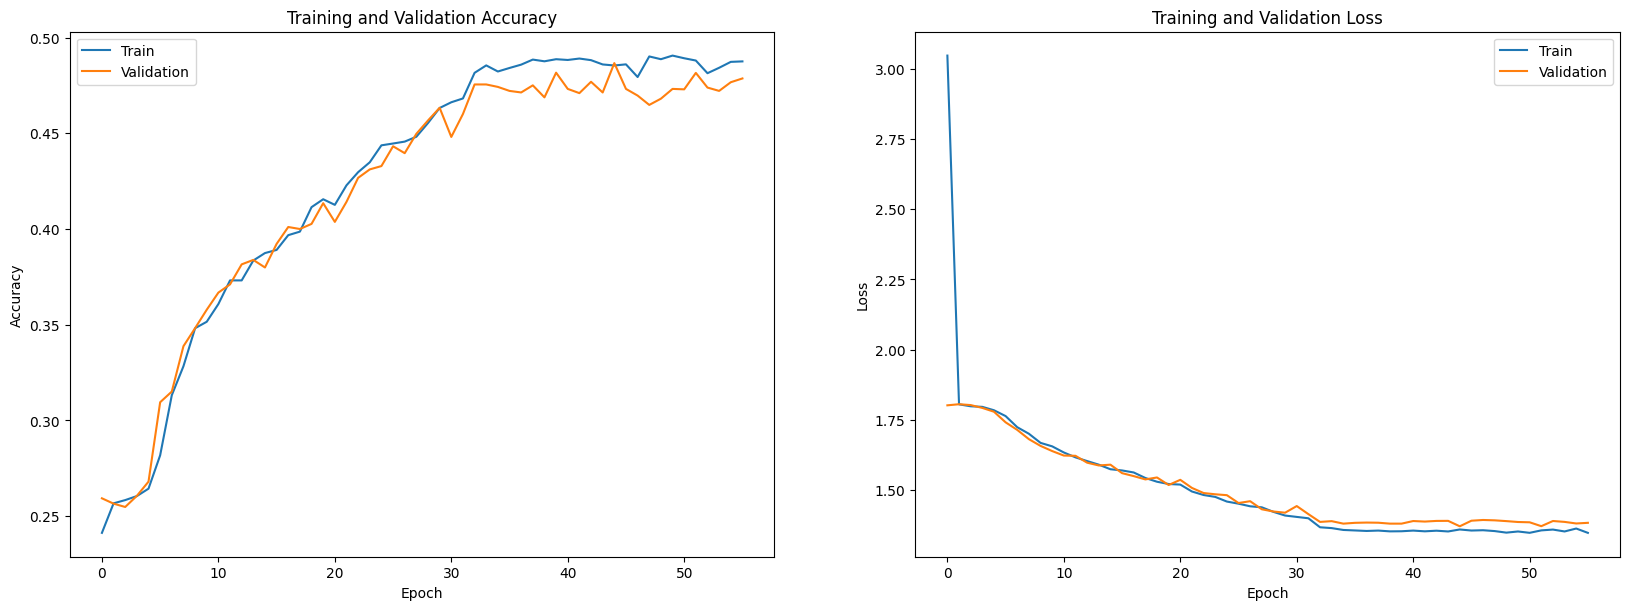

In [16]:

from pylab import rcParams
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
start_epoch = 0
Epoch_count=len(acc)+ start_epoch
Epochs=[]
for i in range (start_epoch ,Epoch_count):
    Epochs.append(i+1)   
index_loss=npy.argmin(val_loss)   #   this is the epoch with the lowest validation loss
val_lowest=val_loss[index_loss]
index_acc=npy.argmax(val_acc)

confusion_matrix()
# summarize history for accuracy using reLU
plt.figure(figsize=(20, 15))
plt.subplot(2, 2, 1)
plt.plot(acc)
plt.plot(val_acc)
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')



# summarize history for loss using reLU
plt.subplot(2, 2, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


## Making Predictions

In [ ]:
# Function to Plot Confusion Matrix on the Test Set
def ConfusionMatrix(label_test, label_prep, class_count, class_keys, head = ''):
    from sklearn.metrics import confusion_matrix, accuracy_score
    cm = confusion_matrix(label_test, label_prep)
    accuracy = accuracy_score(label_test, label_prep)

    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
    plt.xticks(npy.arange(class_count)+.5, class_keys, rotation=90)
    plt.yticks(npy.arange(class_count)+.5, class_keys, rotation=0)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix"+head)
    plt.show() 
    clr = classification_report(
                                label_test, 
                                label_prep, 
                                target_names=class_keys, 
                                digits= 4
                                ) # create classification report
    print(f"Classification Report {head}:\n---------------------------------------------\n", clr)

    print('accuracy: ', accuracy)


## Batch Size Predictions 

In [ ]:
def ViewPredictionAndTestLabels(model, test_generator, batch_size):
    test_images, test_labels = next(test_generator)
    preds = model.predict(test_images)
    label_prep = npy.argmax(preds, axis = 1)
    label_test = npy.argmax(test_labels, axis = 1)
    correct_prediction = npy.sum((label_test == label_prep)*1)/batch_size
    print(label_prep)
    print(label_test)
    print('Correct Prediction:', correct_prediction)
    return label_test, label_prep

label_test, label_prep = ViewPredictionAndTestLabels(
                                                    model=cnn_model, 
                                                    test_generator=test_generator, 
                                                    batch_size=batch_size
                                                    )

2/2 [==============================] - 0s 14ms/step
[2 2 6 2 3 2 5 2 2 2 0 2 6 3 0 2 4 6 4 4 2 6 5 2 2 2 2 2 2 2 2 6 2 2 2 0 2
 2 5 0 2 6 4 3 6 6 6 5 2 2 2 2 4 2 2 2 2 2 5 2 5 2 3 4]
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
Correct Prediction: 0.546875


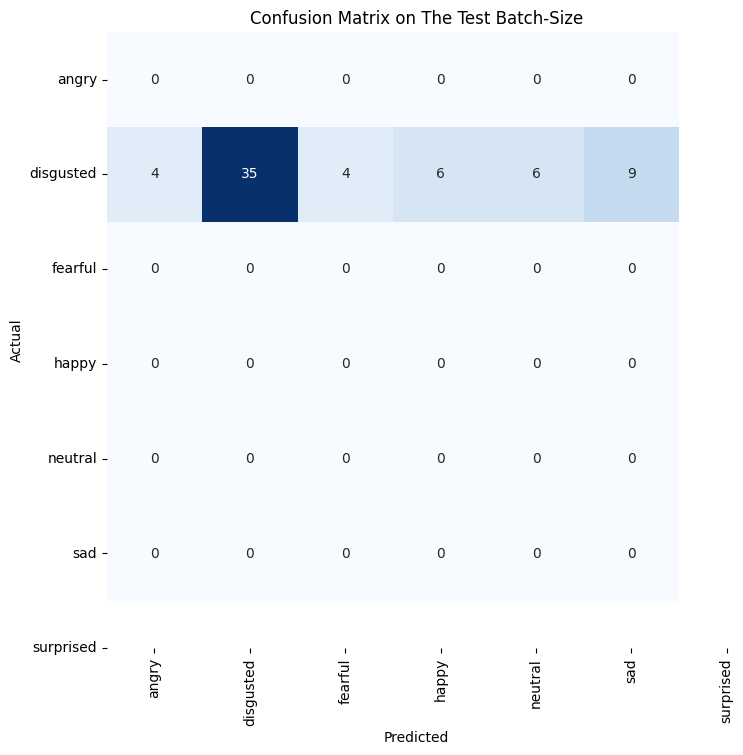

ValueError: Number of classes, 6, does not match size of target_names, 7. Try specifying the labels parameter

In [ ]:
# Plot Confusion Matrix with Classification Report on the test batch-size data
ConfusionMatrix(
                label_test, 
                label_prep, 
                class_count, 
                class_keys,
                head=' on The Test Batch-Size'
                )

113/113 [==============================] - 5s 40ms/step

3424 out of 7178 tested images could not be detected properly given an accuracy of  52.30



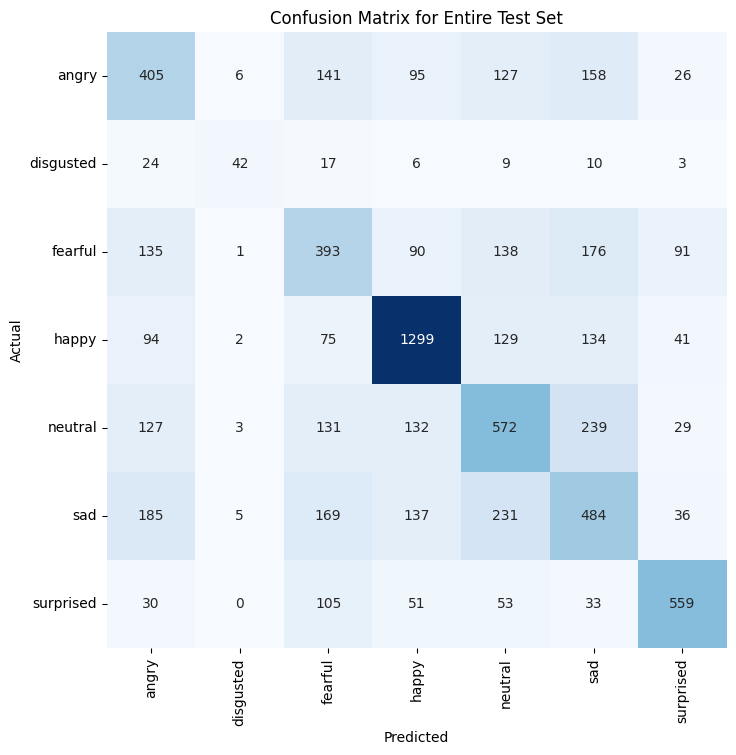

Classification Report  for Entire Test Set:
---------------------------------------------
               precision    recall  f1-score   support

       angry     0.4050    0.4228    0.4137       958
   disgusted     0.7119    0.3784    0.4941       111
     fearful     0.3812    0.3838    0.3825      1024
       happy     0.7177    0.7322    0.7249      1774
     neutral     0.4543    0.4639    0.4591      1233
         sad     0.3922    0.3881    0.3902      1247
   surprised     0.7121    0.6727    0.6918       831

    accuracy                         0.5230      7178
   macro avg     0.5392    0.4917    0.5080      7178
weighted avg     0.5254    0.5230    0.5233      7178

accuracy:  0.5229869044302033


In [ ]:
# 
def ModelPredictionOnTestDataset(test_generator):
    y_pred= []
    y_label=test_generator.labels
    classes=list(train_generator.class_indices.keys())
    class_count=len(classes)
    wrong_predictions=0
    
    # predict on the test set
    preds=cnn_model.predict(test_generator) 
    
    total_predictions=len(preds)
    for i, p in enumerate(preds):
            pred_index=npy.argmax(p)  
            # labels are integer values       
            true_index=test_generator.labels[i]  
            if pred_index != true_index:       
                # a misclassification has occurred                                     
                wrong_predictions=wrong_predictions + 1
            y_pred.append(pred_index)
    acc=( 1-wrong_predictions/total_predictions) * 100
    print(f'\n{wrong_predictions} out of {total_predictions} tested images could not be detected properly given an accuracy of {acc:6.2f}\n')
    ypred=npy.array(y_pred)
    ytrue=npy.array(y_label)
    if class_count <=30:
        # Plot the confusion matrix
        ConfusionMatrix(
                        label_test=ytrue, 
                        label_prep=ypred, 
                        class_count=class_count, 
                        class_keys=class_keys, 
                        head=' for Entire Test Set'
                        )
        
    return wrong_predictions, total_predictions

wrong_predictions, total_predictions = ModelPredictionOnTestDataset(test_generator)

In [ ]:
#Code by Hitesh Kumar https://www.kaggle.com/hitzz97/emotion-detection

# x,y = test.next()
test_images, test_labels = next(test_generator)
preds = cnn_model.predict(test_images)
# print(preds)
idx = npy.argmax(preds, axis = 1)
# test_labels = test_labels.astype(int)
test_labels = npy.argmax(test_labels, axis = 1)
idx = idx.reshape((-1, 1))
test_labels = npy.reshape(test_labels, (len(test_labels), 1))
print(test_labels, idx, end=' ')
# print()
print('correct prediction:', npy.sum((test_labels == idx)*1)/32)
test_labels == idx


2/2 [==============================] - 0s 14ms/step
[[5]
 [4]
 [4]
 [5]
 [5]
 [5]
 [6]
 [3]
 [2]
 [4]
 [4]
 [6]
 [3]
 [0]
 [3]
 [0]
 [4]
 [3]
 [3]
 [4]
 [4]
 [3]
 [0]
 [2]
 [1]
 [2]
 [0]
 [2]
 [2]
 [3]
 [3]
 [4]
 [4]
 [6]
 [2]
 [4]
 [4]
 [3]
 [0]
 [0]
 [2]
 [0]
 [6]
 [3]
 [2]
 [3]
 [0]
 [3]
 [3]
 [3]
 [6]
 [0]
 [0]
 [3]
 [4]
 [2]
 [6]
 [2]
 [4]
 [0]
 [0]
 [0]
 [5]
 [3]] [[0]
 [5]
 [0]
 [0]
 [4]
 [5]
 [6]
 [3]
 [5]
 [4]
 [4]
 [6]
 [3]
 [0]
 [6]
 [2]
 [4]
 [0]
 [3]
 [3]
 [5]
 [3]
 [0]
 [2]
 [1]
 [3]
 [5]
 [5]
 [2]
 [3]
 [0]
 [4]
 [4]
 [6]
 [0]
 [5]
 [0]
 [3]
 [0]
 [3]
 [2]
 [5]
 [6]
 [3]
 [5]
 [3]
 [4]
 [3]
 [3]
 [3]
 [6]
 [2]
 [5]
 [3]
 [3]
 [0]
 [6]
 [6]
 [4]
 [3]
 [2]
 [0]
 [5]
 [5]] correct prediction: 1.0625


array([[False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [

In [ ]:

def compare(idx, train_generator):
    class_dictionary = train_generator.class_indices
    for key, value in class_dictionary.items():
        if value == idx:
             return key

def dif(test_labels, idx, train_generator):    
    class_dictionary = train_generator.class_indices
    test = ''
    id = ''
    for key, value in class_dictionary.items():
        if value == test_labels:
            test = key
        if value == idx:
            id = key
    return test, id



if idx[1] == test_labels[1]:
    compare(idx[12],train_generator)
else:
    test, id = dif(test_labels[1], idx[0], train_generator)
    print(f'id: {id}')
    print(f'test: {test}')
    print(dif(test_labels[1], idx[0], train_generator)[0])
    



id: angry
test: neutral
neutral


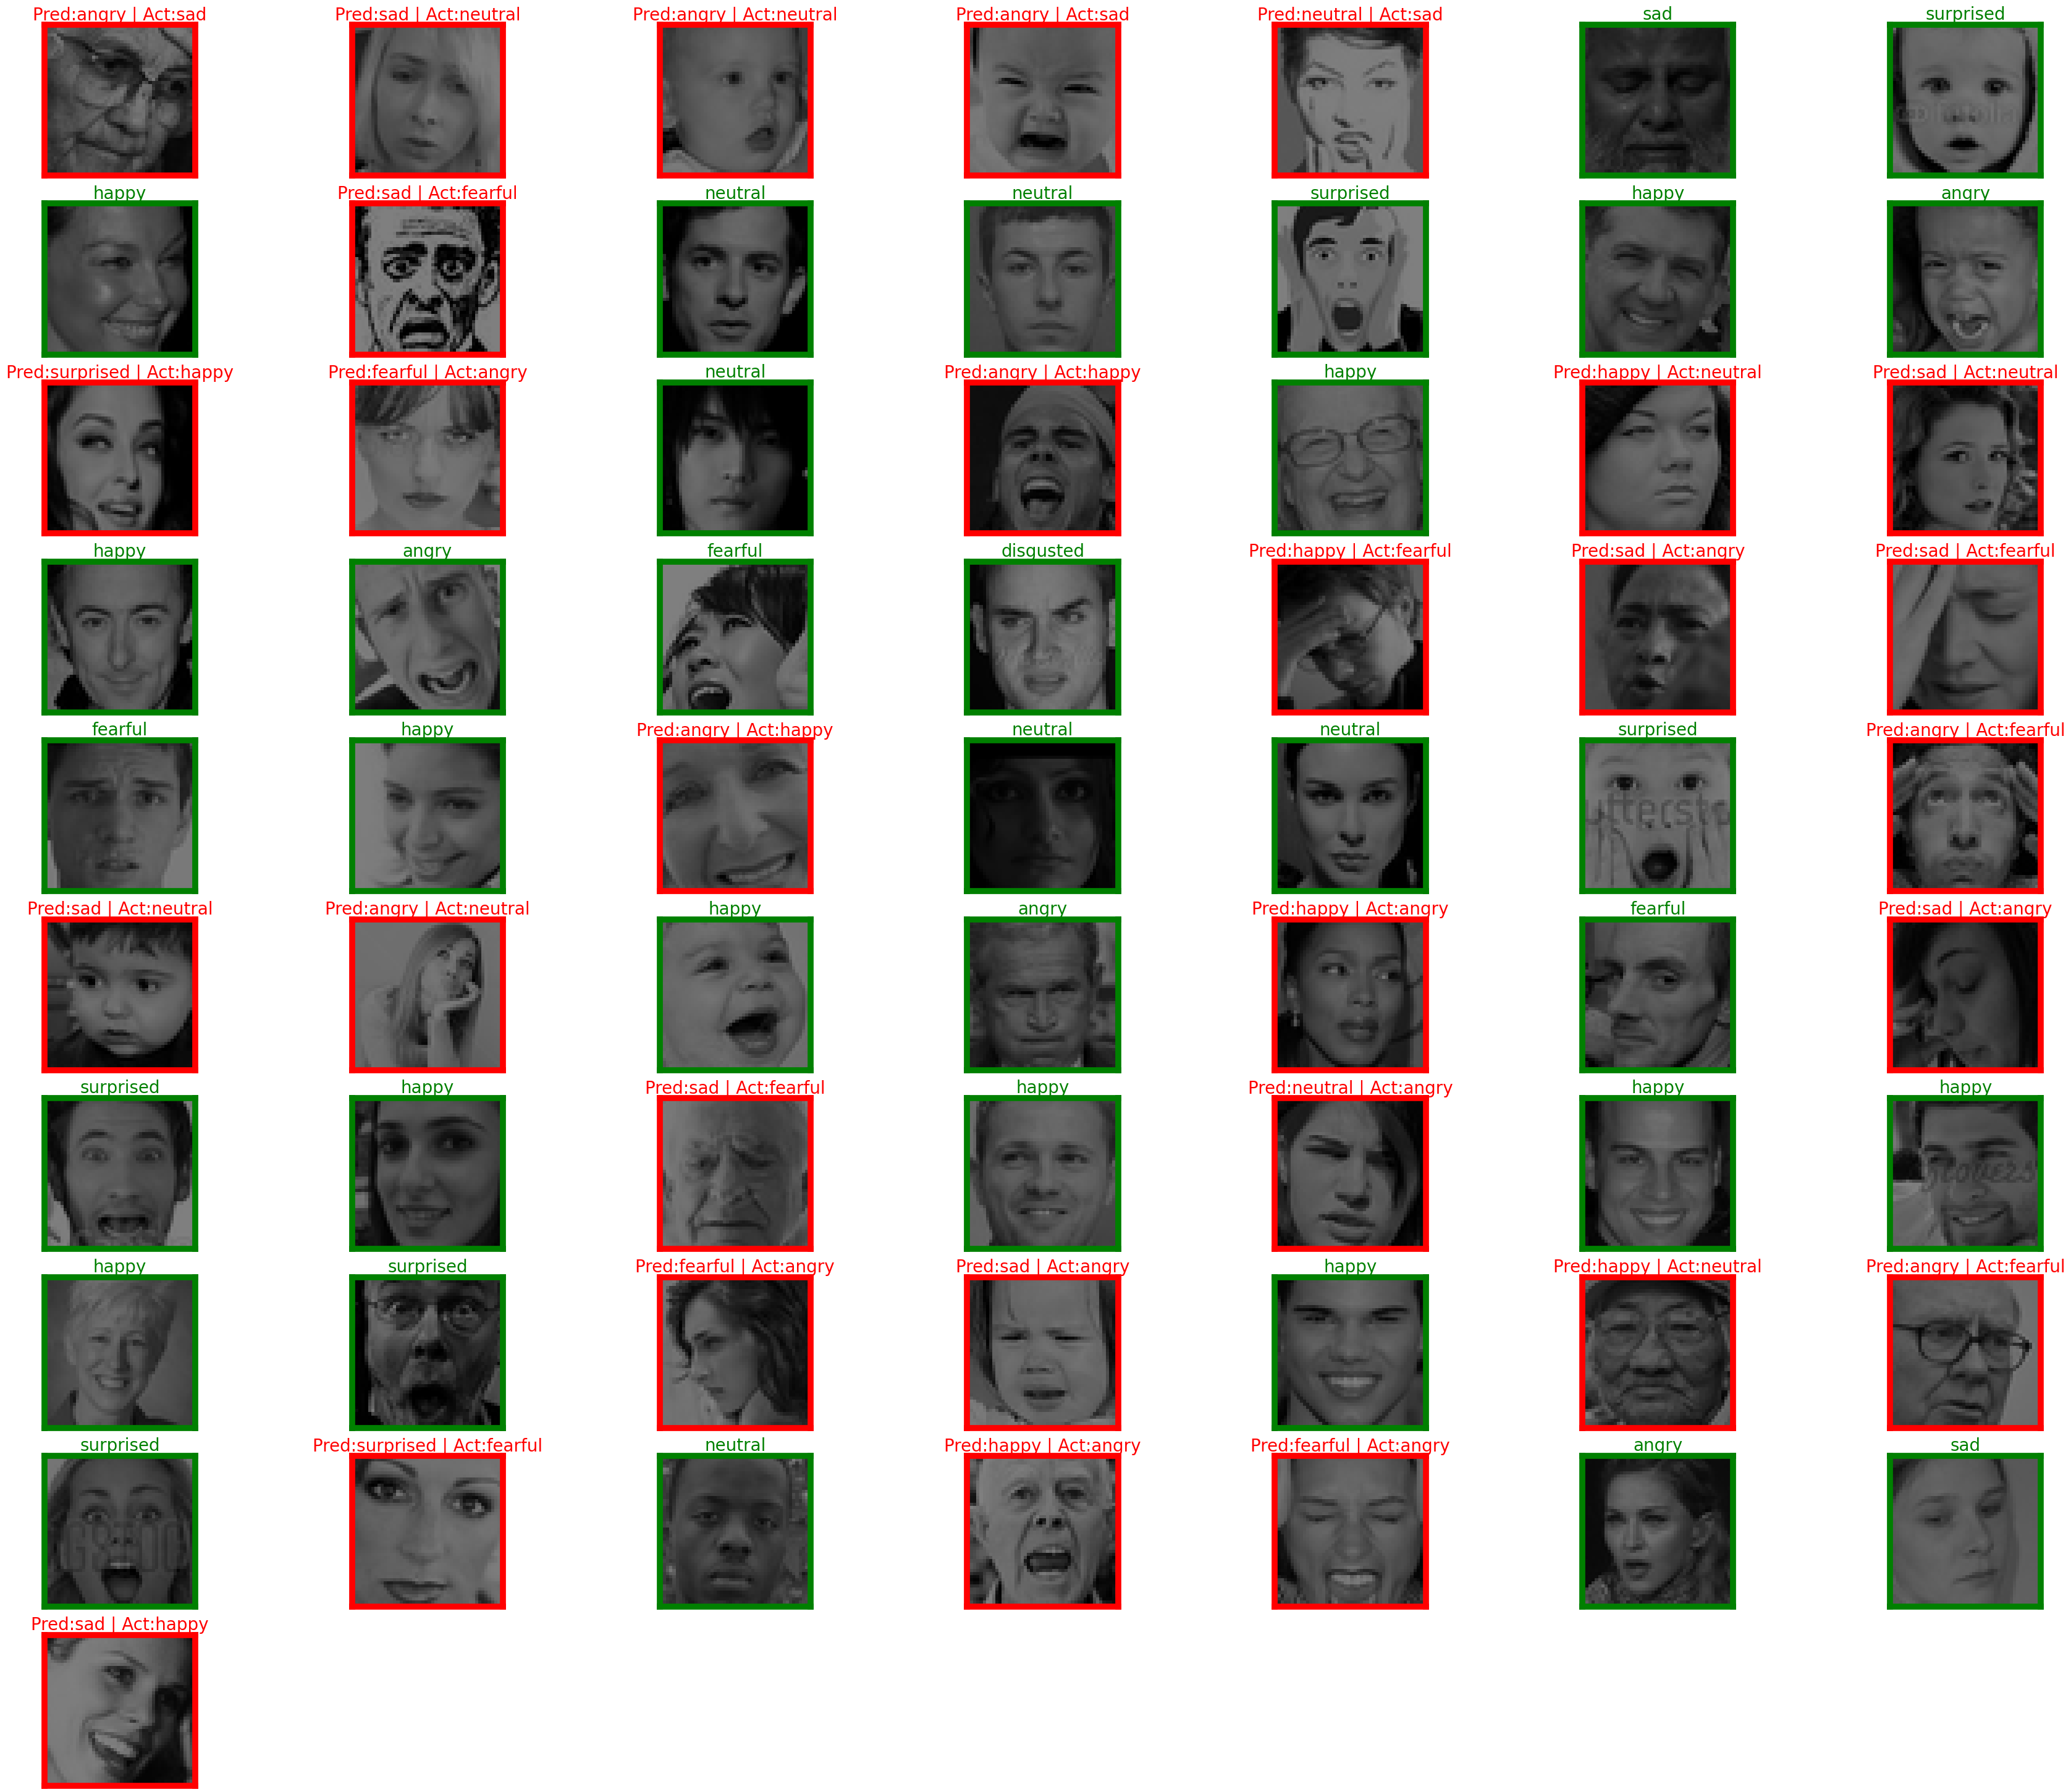

In [ ]:
#Code by Hitesh Kumar https://www.kaggle.com/hitzz97/emotion-detection

fig = plt.figure(figsize=(35, batch_size/2))

# k = 0
for j in range(len(idx)):
    ax = plt.subplot(int(batch_size/6)+1, 7, j+1)
    px = test_images[j]/512
#     k += 1
    ax.imshow(px)
    ax.set_xticks([])
    ax.set_yticks([])
    
#     print(idx[j])
#     print(test_labels[j])
    if test_labels[j] == idx[j]:
#     if  class_dictionary[test_labels[j]] == class_dictionary[idx[j]]:
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(7)
            ax.spines[axis].set_color('green')
        ax.set_title(
                    compare(idx[j], train_generator),
                    color='green', 
                    fontsize=20
                     )

    else:
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(7)
            ax.spines[axis].set_color('red')
        ax.set_title(
                    'Pred:'+dif(test_labels[j], idx[j], train_generator)[1]+" | Act:"+ dif(test_labels[j], idx[j], train_generator)[0],
                    color='red', 
                    fontsize=20
                    )
    plt.tight_layout()

113/113 [==============================] - 5s 46ms/step


KeyError: 3

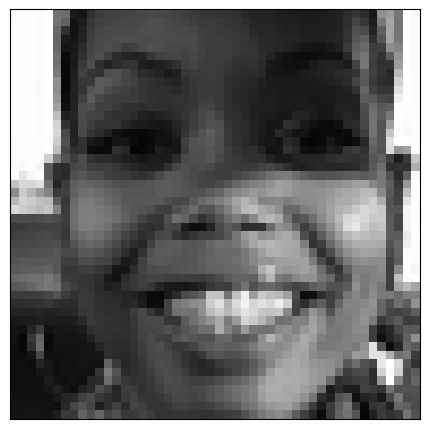

In [ ]:
# Plot the Predicted Images
def plotPredictedImages(model, test_generator):
    test_images, test_labels = next(test_generator)
    
    preds = model.predict(test_generator)
    label_prep = npy.argmax(preds, axis = 1)
    label_test = npy.argmax(test_labels, axis = 1)

    fig = plt.figure(figsize=(33, 50))
    # classes = train_generator.class_indices
    k = 0
    for i in range(32):
        ax = plt.subplot(8, 4, i+1)
        px = test_images[i]/255
        ax.imshow(px) #, cmap='Accent')
        ax.set_xticks([])
        ax.set_yticks([])
        
        if  class_dictionary[label_test[i]] == class_dictionary[label_prep[i]]:
            for spine in ['top','bottom','left','right']:
                ax.spines[spine].set_linewidth(10)
                ax.spines[spine].set_color('green')
            ax.set_title(
                        class_dictionary[label_prep[i]],
                        color='green', 
                        fontsize=40
                        )
        else:
            for spine in ['top','bottom','left','right']:
                ax.spines[spine].set_linewidth(10)
                ax.spines[spine].set_color('red')
            labels='Pred:'+class_dictionary[label_prep[i]]+" | Act:"+class_dictionary[label_test[i]],
            ax.set_title(
                        label=labels,
                        color='red', 
                        fontsize=35
                        )
        plt.tight_layout()
    
plotPredictedImages(cnn_model, test_generator)